In [1]:
#Simple GAN implementation
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import clear_output
import logging
from ipywidgets.widgets.interaction import show_inline_matplotlib_plots
%matplotlib inline

BATCH_SIZE = 256

/home/kmills/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class DataStreamer(object):
    """
    Class for reading csv data from the output file of generateconfigs.jl,
    and providing shuffled batching.   
    """
    def __init__(self, csvfile, fake=False):
        with open(csvfile, 'rb') as F:
            cleaned_lines = (line.replace(b';',b',') for line in F)
            data  = np.genfromtxt(cleaned_lines, dtype=int, delimiter=',')
            N = int(((data.shape[1] - 1) / 2))
            configs = data[:,-(N+1):-1].reshape((-1,N))
    
        self.data = configs
        self.data[self.data==0]=-1
        self.example_shape = self.data.shape[1:]
        self.epoch = -1
        self.__new_epoch()
        logging.info("Data shape: " + str(self.data.shape))

        """Here I (conditionally) override the csv data with some 'easy'
           data to test the GAN implementation"""
        if False:
            #Single pixel, always in the same place:  SUCCESS
            self.data = np.zeros_like(self.data) - 1
            self.data[:,1] = 1

            #Vertical lines
            self.data = np.zeros_like(self.data) - 1
            for i in range(self.data.shape[0]):
                d = self.data[i, :].reshape((4,4))
                d[:,np.random.randint(0,4)] = 1
                self.data[i,] = d.flatten()
        
        
    def __new_epoch(self):
        """
        Reset the queue of shuffled indices that will be removed as we
        return examples.  Increment the epoch counter.
        """
        self.epoch += 1
        indices = np.arange(self.data.shape[0])
        np.random.shuffle(indices)
        self.q = list(indices)
    
    def next_batch(self, batch_size):
        """Return batch_size examples in an array."""
        batch_data = np.zeros([batch_size,] + list(self.example_shape))
        for i in range(batch_size):
            index = self.q.pop()
            batch_data[i,...] = self.data[index]
            if len(self.q)==0:
                self.__new_epoch()
               
        return batch_data


In [3]:
class Generator(object):
    """
       Construct the generator, taking a batch of random noise vectors and returning
       a tensor representing a batch of generated examples.  Arbitrary tensorflow neural
       network ops can be inserted here.
    """
    def __init__(self, z, output_shape, scope='G'):
        with tf.variable_scope(scope) as scope:
            output = z
            output = tf.layers.dense(output, 256, activation=tf.nn.leaky_relu)
            output = tf.layers.dense(output, 512, activation=tf.nn.leaky_relu)
            output = tf.layers.dense(output, 1024, activation=tf.nn.leaky_relu)
            output = tf.layers.dense(output, 512, activation=tf.nn.leaky_relu)
            output = tf.layers.dense(output, 256, activation=tf.nn.leaky_relu)
            output = tf.layers.dense(output, 128, activation=tf.nn.leaky_relu)
            output = tf.layers.dense(output, np.prod(output_shape), activation=tf.nn.tanh)            
            self.output = tf.reshape(output, (-1,) + output_shape)

In [4]:
class Discriminator(object):
    """
       Construct the Discriminator, taking a batch of "examples" (either real or generated) 
       and returning an unactivated output indicating how "real" the example is considered.
       Since this is unactivated, some refer to this as a "Critic" instead of "Discriminator".
    """
    def __init__(self, x_in, scope='D'):
        with tf.variable_scope(scope, reuse=tf.AUTO_REUSE) as scope:
            output = x_in
            output = tf.layers.dense(output, 128, activation=tf.nn.leaky_relu)
            output = tf.layers.dense(output, 256, activation=tf.nn.leaky_relu)
            output = tf.layers.dense(output, 512, activation=tf.nn.leaky_relu)
            output = tf.layers.dense(output, 1024, activation=tf.nn.leaky_relu)
            output = tf.layers.dense(output, 1, activation=None)
            self.output = output
            

In [5]:
class Random(object):
    """
    Simple class for generating random latent noise.
    """
    def __init__(self):
        pass
    def sample(self, shape):
        return np.random.normal(loc=0.0, scale=0.1, size=shape)

In [6]:
class Visualiser(object):
    """
    Simple plotting helper to plot some ground truth training examples beside the generator
    output.  Use threshold=True to 'snap' the plot to -1 and 1.
    """
    
    def __init__(self, batch_size):
        self.batch_size = batch_size
        pass
    def update(self, G_out, truth, threshold=False):
        assert sample.shape[0]==self.batch_size,"first dimension of sample must be equal to batch_size"
        N = int(np.sqrt(self.batch_size))
        if threshold:
            G_out[G_out < 0] = -1
            G_out[G_out >= 0] = 1
        N = min(N, 5)
        fig, ax = plt.subplots(N,2*N,figsize=(20,10))
        for k, d in enumerate([sample, ground_truth]):
            counter = 0
            for i in range(N):
                for j in range(k*N,(k+1)*N):
                    ax[i,j].pcolormesh(d[counter].reshape(4,4), cmap='gray', vmin=-1, vmax=1)
                    ax[i,j].set_xticks([])
                    ax[i,j].set_yticks([])
                    counter += 1
        fig.show()
        show_inline_matplotlib_plots()
                    

In [7]:
"""
Here we instantiate and connect the pieces, define the loss functions, 
perform the weight clipping (for WGAN) on the discriminator, and set up the optimizer.
"""

tf.reset_default_graph()

S = DataStreamer("../ising.csv")

z_ph = tf.placeholder(tf.float32, shape=(BATCH_SIZE, 128), name="input_noise")
x_ph = tf.placeholder(tf.float32, shape=tuple([BATCH_SIZE,] + list(S.example_shape)), name="true_sample")
lr = tf.placeholder(tf.float32, shape=(), name='learning_rate')

R = Random()
G = Generator(z_ph, output_shape=S.example_shape)
DR = Discriminator(x_ph)
DG = Discriminator(G.output)
V = Visualiser(BATCH_SIZE)

D_loss = tf.reduce_mean(DR.output) - tf.reduce_mean(DG.output)
G_loss = -tf.reduce_mean(DG.output)

D_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='D')
G_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='G')

D_clip = [p.assign(tf.clip_by_value(p, -0.01, 0.01)) for p in D_vars]

D_optimizer = tf.train.RMSPropOptimizer(lr)
G_optimizer = tf.train.RMSPropOptimizer(lr)

D_step = D_optimizer.minimize(-D_loss, var_list=D_vars)
G_step = G_optimizer.minimize(G_loss, var_list=G_vars)

init = tf.global_variables_initializer()

In [8]:
sess = tf.Session()
sess.run(init)

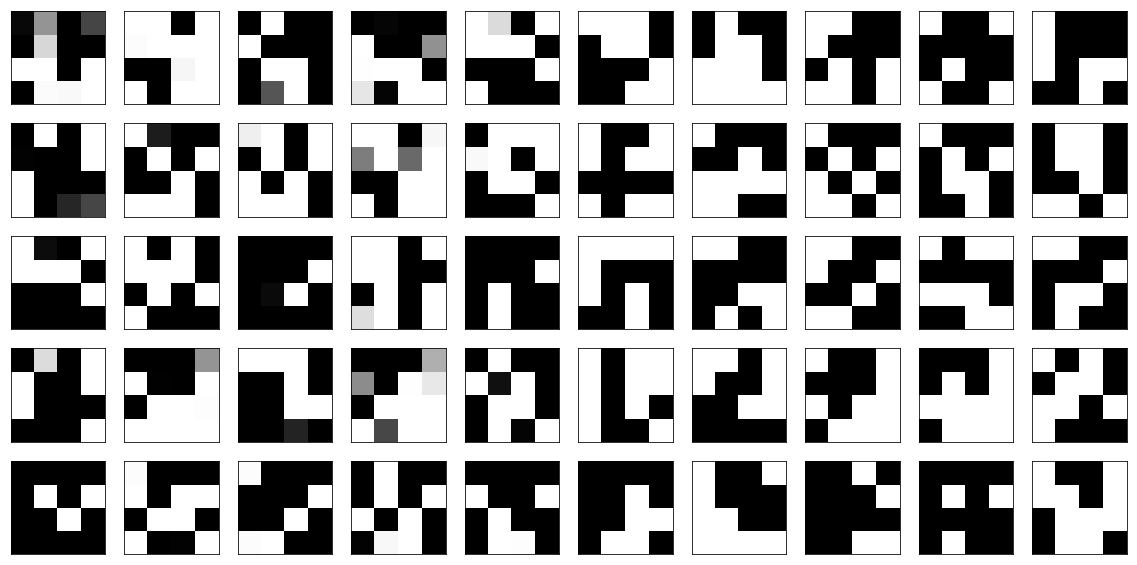

Epoch   858	Gl: 1.020e-01	Dl: 2.332e-01


KeyboardInterrupt: 

In [9]:
"""
Now the actual training.
"""

"""
Generate a random vector that will be used for plotting (so we can see the evolution
of the generator on the same latent input.  Additionally we want the ground truth data
to be the same in every frame.
"""
static_random = R.sample(z_ph.shape)
ground_truth = S.next_batch(BATCH_SIZE)

N = int(np.sqrt(BATCH_SIZE))


for iteration in range(10000000):

    for _ in range(5):
        #train the Discriminator for five steps
        x_in = S.next_batch(BATCH_SIZE)
        _, D_loss_val, _ = sess.run([D_step, D_loss, D_clip], 
                                feed_dict = {x_ph: x_in,
                                             z_ph: R.sample(z_ph.shape),
                                             lr: 0.0001
                                            })
        
    _, G_loss_val = sess.run([G_step, G_loss], feed_dict={z_ph:R.sample(z_ph.shape),
                                                          lr: 0.0001})
    if iteration % 10 == 0:
        sample = sess.run(G.output, feed_dict={z_ph: static_random})
        
        clear_output(wait=True)
        
        V.update(sample, ground_truth, threshold=False)
        print("Epoch {:5d}\tGl: {:5.3e}\tDl: {:5.3e}".format(S.epoch, G_loss_val, D_loss_val))



## Results:

After 10-ish minutes of training (~850 epochs), it arrives at something that doesn't look
_completely_ wrong at first glance.  More work to be done though.